# Confusion Matrix — All Classes

This notebook loads class names and saved predictions/labels (from common locations) and plots a full confusion matrix for all classes.

How to use:
- If you already have a `predictions.csv` with columns `true` and `pred`, or `y_true.npy` and `y_pred.npy`, the notebook will try to find them automatically.
- Otherwise, run your model evaluation to export those arrays or provide a CSV.

In [1]:
# Cell 2: Imports and plotting settings
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set(style="whitegrid", font_scale=0.9)

In [2]:
# Cell 3: Load class names (tries root `class_names.json`)
base = Path('..').resolve()  # notebook runs inside nutrisight_model_training folder typically
candidates = [Path('class_names.json'), Path('..') / 'class_names.json', base / 'class_names.json']
class_names = None
for p in candidates:
    if p.exists():
        try:
            with open(p, 'r', encoding='utf-8') as f:
                class_names = json.load(f)
            print(f'Loaded class names from: {p}')
            break
        except Exception as e:
            print(f'Failed to load {p}:', e)
if class_names is None:
    print('Could not find `class_names.json`. You can still proceed by providing `labels` and `preds` arrays or a `predictions.csv`.')

Loaded class names from: ..\class_names.json


In [3]:
# Cell 4: Robust loader for predictions/labels
def try_load_predictions():
    # Try a few common file names and locations
    cwd = Path('.')
    tries = [
        cwd / 'predictions.csv',
        cwd / 'preds.csv',
        cwd / 'predictions' / 'predictions.csv',
        Path('..') / 'predictions.csv',
        cwd / 'y_true.npy',
        cwd / 'y_pred.npy',
        cwd / 'y_preds.npy',
        cwd / 'predictions.npy',
    ]
    for p in tries:
        if p.exists():
            print(f'Found: {p}')
            try:
                if p.suffix == '.csv':
                    df = pd.read_csv(p)
                    if {'true','pred'}.issubset(df.columns):
                        return np.asarray(df['true']), np.asarray(df['pred'])
                    # Try common names
                    if {'label','prediction'}.issubset(df.columns):
                        return np.asarray(df['label']), np.asarray(df['prediction'])
                    # If only one column, assume order true,pred or pred,true is not safe - skip
                elif p.suffix == '.npy':
                    # Expect pairs: y_true.npy and y_pred.npy; if file is predictions.npy, expect dict-like or 2-col array
                    arr = np.load(p, allow_pickle=True)
                    # If single array with shape (N,2)
                    if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == 2:
                        return arr[:,0], arr[:,1]
                    # if the filename contains 'true' or 'pred' return accordingly
                    if 'true' in p.name.lower():
                        y_true = arr
                        p_pred = p.with_name(p.name.replace('true','pred'))
                        if p_pred.exists():
                            y_pred = np.load(p_pred, allow_pickle=True)
                            return y_true, y_pred
            except Exception as e:
                print('Failed to load', p, e)
    return None, None

y_true, y_pred = try_load_predictions()
if y_true is None or y_pred is None:
    print(
        "No predictions found automatically.\n"
        "Please either:\n"
        "- Place a `predictions.csv` with columns `true` and `pred` in this folder, or\n"
        "- Save `y_true.npy` and `y_pred.npy` in this folder, or\n"
        "- Manually set `y_true` and `y_pred` arrays in the next cell."
    )

No predictions found automatically.
Please either:
- Place a `predictions.csv` with columns `true` and `pred` in this folder, or
- Save `y_true.npy` and `y_pred.npy` in this folder, or
- Manually set `y_true` and `y_pred` arrays in the next cell.


In [4]:
# Cell 5: If automatic load failed, provide a place to paste or construct arrays manually
# Example (uncomment and edit if needed):
# import numpy as np
# y_true = np.array([0,1,2,0,1])
# y_pred = np.array([0,2,2,0,0])

try:
    _ = len(y_true)
    print('y_true and y_pred are loaded with', len(y_true), 'samples')
except Exception:
    # keep definitions local for user to edit
    print('No `y_true`/`y_pred` arrays are defined. Edit the example above or provide files as instructed.')

No `y_true`/`y_pred` arrays are defined. Edit the example above or provide files as instructed.


In [5]:
# Cell 5b: Try to recreate predictions by loading the saved best model and running evaluation on the test split
# This will produce and save `y_true.npy` and `y_pred.npy` in the notebook folder so the plotting cells can use them.
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from pathlib import Path

def find_best_checkpoint():
    # Look for summary.json or best_*.pth in nearby run folders
    cwd = Path('.')
    # check common run folder pattern in parent dirs and workspace
    candidates = list(cwd.glob('**/summary.json')) + list(cwd.glob('**/best_*.pth'))
    for p in candidates:
        if p.name == 'summary.json':
            try:
                import json
                s = json.load(open(p, 'r', encoding='utf-8'))
                bm = s.get('files', {}).get('best_model')
                if bm and Path(bm).exists():
                    return Path(bm)
            except Exception:
                continue
        else:
            # direct checkpoint file
            if p.suffix == '.pth' and p.exists():
                return p
    return None

best = find_best_checkpoint()
if best is None:
    print('No trained checkpoint found automatically (no best_*.pth or summary.json). Skip auto-eval.')
else:
    print(f'Found checkpoint: {best}')
    ckpt = torch.load(str(best), map_location='cpu')
    classes_ckpt = ckpt.get('classes') or ckpt.get('classes', None)
    if classes_ckpt is None:
        print('Checkpoint does not contain `classes`. Aborting auto-eval.')
    else:
        num_classes = len(classes_ckpt)
        # build model skeleton and load weights
        model = models.efficientnet_b3(weights=None)
        in_f = model.classifier[1].in_features
        model.classifier = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(in_f, num_classes))
        try:
            model.load_state_dict(ckpt['model_state'])
        except Exception as e:
            print('Failed to load model state dict:', e)
        model.eval()
        # find dataset root (common path used in training)
        possible_roots = [Path('d:/VSC FILES/testtrain/splits_new_v2'), Path('..') / 'splits_new_v2', Path('..') / '..' / 'splits_new_v2']
        data_root = None
        for pr in possible_roots:
            if pr.exists():
                data_root = pr
                break
        if data_root is None:
            print('Dataset root not found automatically. Provide your `splits_new_v2` path or place y_true/y_pred files.')
        else:
            print(f'Using dataset root: {data_root}')
            # recreate simple test dataset loader (no advanced transforms needed)
            image_size = ckpt.get('image_size', 252)
            mean = ckpt.get('mean', [0.485, 0.456, 0.406])
            std = ckpt.get('std', [0.229, 0.224, 0.225])
            eval_tfms = transforms.Compose([
                transforms.Resize(image_size + 32),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
            # simple dataset that returns (img_tensor, label) reading from split folders
            class SimpleSplitDataset(torch.utils.data.Dataset):
                def __init__(self, root, split, classes, transform=None):
                    self.samples = []
                    self.transform = transform
                    for cls in classes:
                        split_dir = Path(root) / cls / split
                        if not split_dir.exists():
                            continue
                        for fp in split_dir.rglob('*'):
                            if fp.suffix.lower() in ('.jpg', '.jpeg', '.png', '.bmp', '.webp'):
                                self.samples.append((fp, classes.index(cls)))
                def __len__(self):
                    return len(self.samples)
                def __getitem__(self, idx):
                    p, label = self.samples[idx]
                    img = Image.open(p).convert('RGB')
                    if self.transform:
                        img = self.transform(img)
                    return img, label
            test_ds = SimpleSplitDataset(data_root, 'test', classes_ckpt, transform=eval_tfms)
            if len(test_ds) == 0:
                print('Test split appears empty under the dataset root. Cannot auto-eval.')
            else:
                test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for imgs, labs in test_loader:
                        outputs = model(imgs)
                        probs = torch.softmax(outputs, dim=1)
                        top1 = probs.argmax(dim=1)
                        all_preds.append(top1.cpu())
                        all_labels.append(labs.cpu())
                all_preds = torch.cat(all_preds).numpy()
                all_labels = torch.cat(all_labels).numpy()
                # Save arrays for later reuse
                import numpy as _np
                _np.save('y_true.npy', all_labels)
                _np.save('y_pred.npy', all_preds)
                print(f'Saved y_true.npy and y_pred.npy ({len(all_labels)} samples)')
                # expose to notebook globals
                y_true = all_labels
                y_pred = all_preds

Found checkpoint: d:\VSC FILES\testtrain\runs\efficientnet_b3_optimized-20251021-115920\best_efficientnet_b3.pth


C:\Users\JP\AppData\Local\Temp\ipykernel_18408\646961204.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(best), map_location='cpu')


Using dataset root: d:\VSC FILES\testtrain\splits_new_v2
Saved y_true.npy and y_pred.npy (4340 samples)


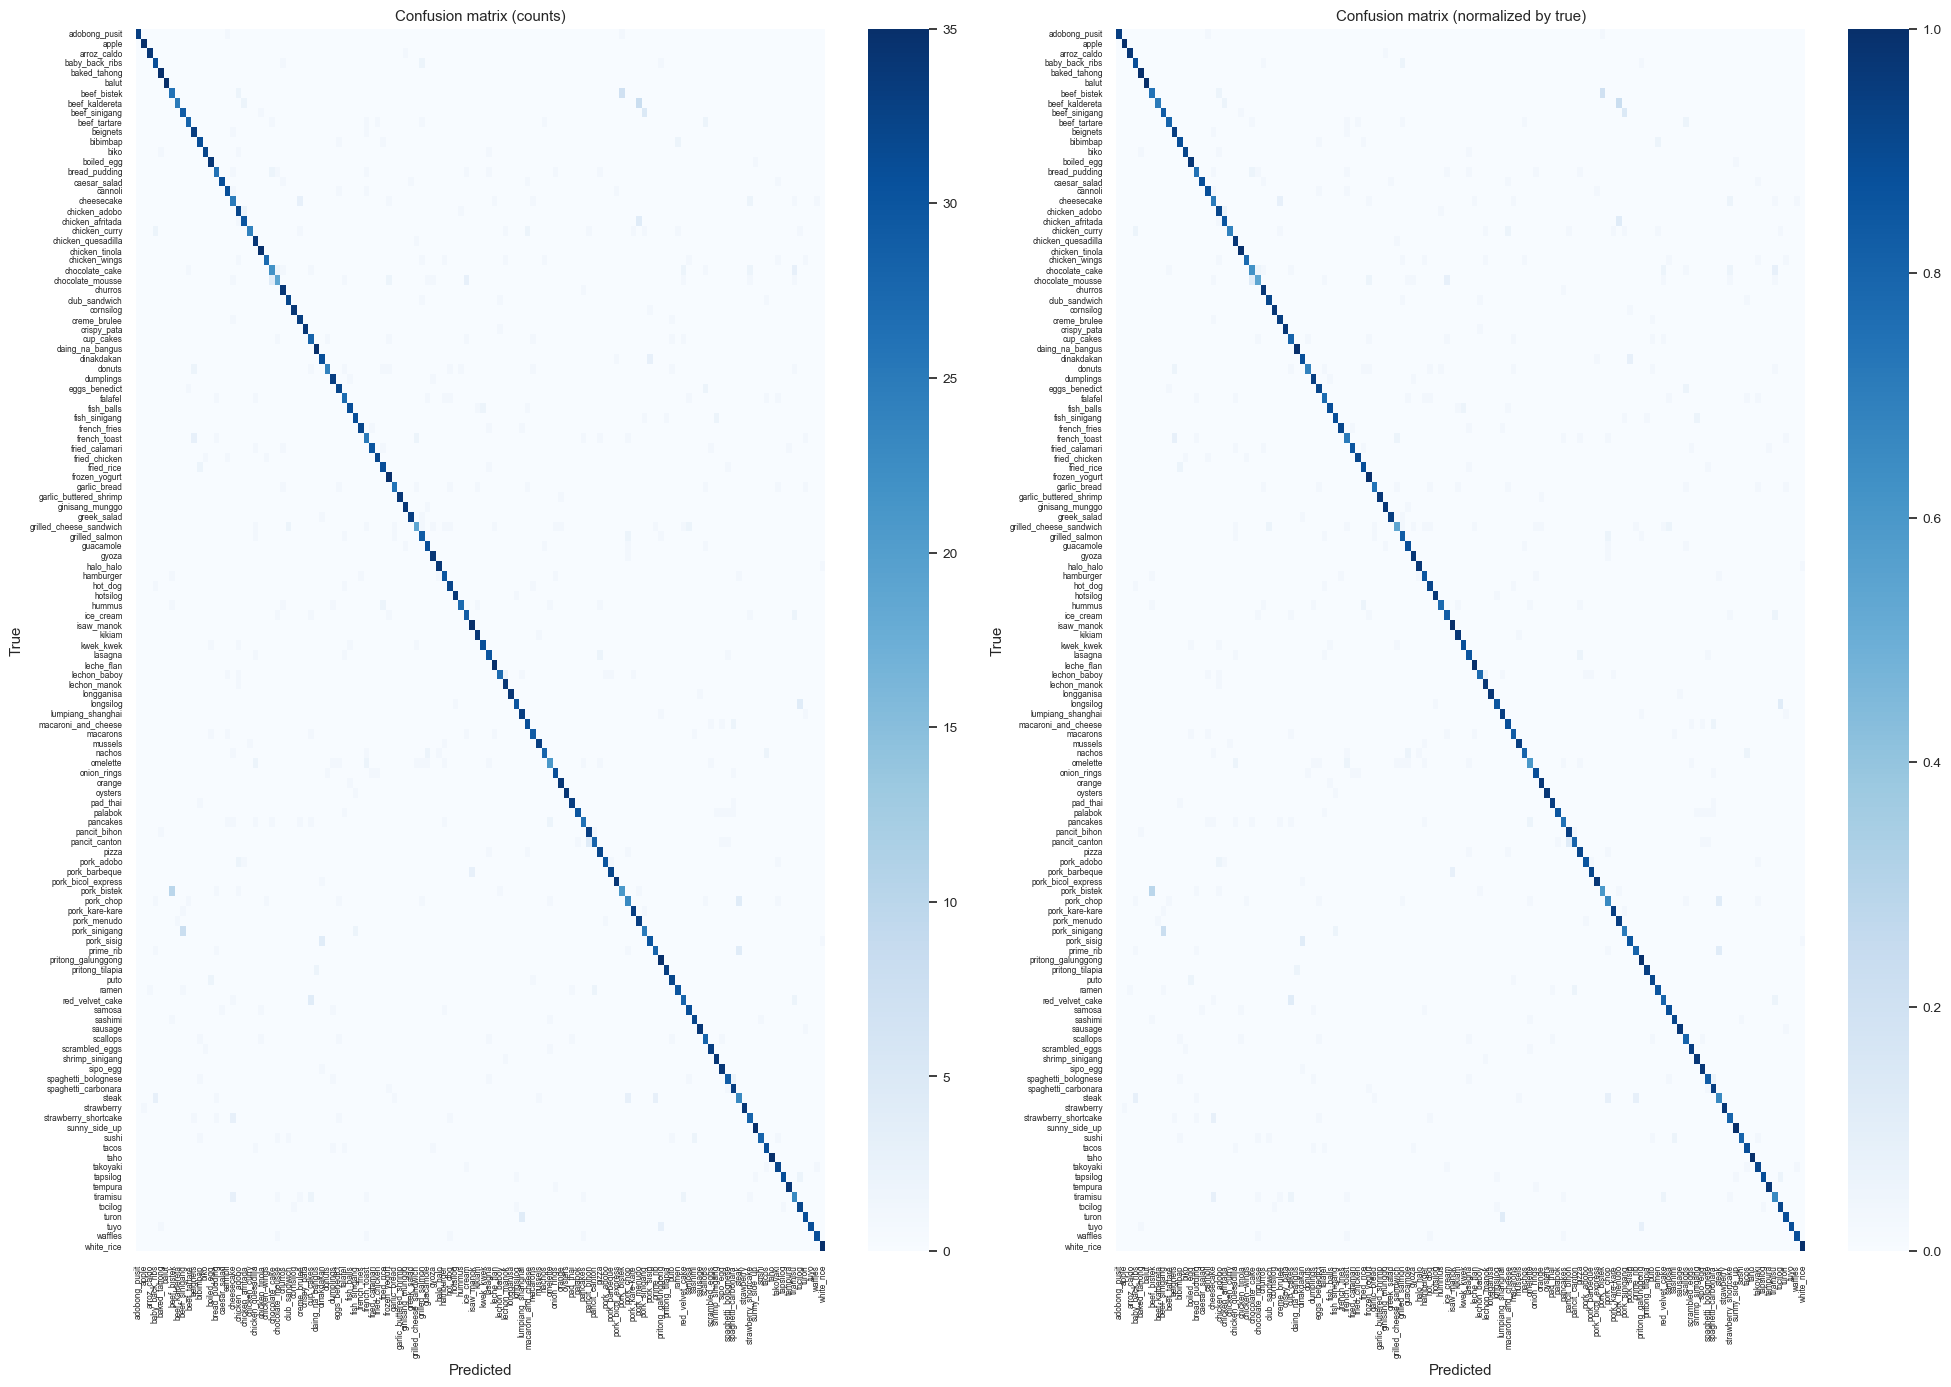

In [6]:
# Cell 6: Compute confusion matrix and plot (counts + normalized)
def plot_confusion(y_true, y_pred, labels=None, figsize=(18,16), normalize=None, cmap='Blues'):
    # labels: list of class names in label index order
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)) if labels is not None else None)
    fig, axes = plt.subplots(1,2, figsize=figsize, gridspec_kw={'width_ratios':[1,1]})
    ax = axes[0]
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=True)
    ax.set_title('Confusion matrix (counts)')
    if labels is not None:
        ax.set_xticks(np.arange(len(labels))+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=6)
        ax.set_yticks(np.arange(len(labels))+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=6)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    # Normalized
    ax2 = axes[1]
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap=cmap, ax=ax2, cbar=True, vmin=0, vmax=1)
    ax2.set_title('Confusion matrix (normalized by true)')
    if labels is not None:
        ax2.set_xticks(np.arange(len(labels))+0.5)
        ax2.set_xticklabels(labels, rotation=90, fontsize=6)
        ax2.set_yticks(np.arange(len(labels))+0.5)
        ax2.set_yticklabels(labels, rotation=0, fontsize=6)
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('True')
    plt.tight_layout()
    return cm, cm_norm

# Run plotting if available
if 'y_true' in globals() and 'y_pred' in globals() and y_true is not None and y_pred is not None:
    # If class names length mismatches, try to infer unique labels
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    if class_names is not None and len(class_names) >= (unique_labels.max()+1):
        labels = [class_names[i] for i in range(len(class_names))]
    else:
        # fallback: string labels from numeric indices
        max_label = int(unique_labels.max())
        labels = [str(i) for i in range(max_label+1)]
    cm, cm_norm = plot_confusion(y_true, y_pred, labels=labels, figsize=(20,14))
    plt.show()
else:
    print('Cannot plot: `y_true`/`y_pred` not found. Provide arrays or files as shown earlier.')

In [7]:
# Cell 7: Show top confusion pairs (helpful to debug)
def top_confusions(cm, labels, top_k=20):
    # mask diagonal (true positives)
    cm_mask = cm.copy().astype(float)
    np.fill_diagonal(cm_mask, 0)
    pairs = []
    for i in range(cm_mask.shape[0]):
        for j in range(cm_mask.shape[1]):
            if cm_mask[i,j] > 0:
                pairs.append((cm_mask[i,j], labels[i], labels[j], i, j))
    pairs = sorted(pairs, key=lambda x: -x[0])
    return pairs[:top_k]

if 'cm' in globals():
    pairs = top_confusions(cm, labels, top_k=30)
    print('Top confusions (count, true_label, predicted_label):')
    for cnt, t, p, ti, pj in pairs:
        print(f'{int(cnt):4d} | True: {t} ({ti}) -> Pred: {p} ({pj})')
else:
    print('No confusion matrix available yet (run the plotting cell first).')

Top confusions (count, true_label, predicted_label):
  10 | True: pork_bistek (87) -> Pred: beef_bistek (6)
   8 | True: beef_kaldereta (7) -> Pred: pork_menudo (90)
   8 | True: pork_sinigang (91) -> Pred: beef_sinigang (8)
   7 | True: beef_bistek (6) -> Pred: pork_bistek (87)
   5 | True: beef_sinigang (8) -> Pred: pork_sinigang (91)
   4 | True: chicken_afritada (19) -> Pred: pork_menudo (90)
   4 | True: chocolate_mousse (25) -> Pred: chocolate_cake (24)
   4 | True: longsilog (68) -> Pred: tocilog (119)
   4 | True: pancit_canton (82) -> Pred: pancit_bihon (81)
   4 | True: pork_chop (88) -> Pred: steak (108)
   4 | True: pork_sisig (92) -> Pred: dinakdakan (33)
   4 | True: prime_rib (93) -> Pred: steak (108)
   4 | True: red_velvet_cake (98) -> Pred: cup_cakes (31)
   4 | True: turon (120) -> Pred: lumpiang_shanghai (69)
   3 | True: cheesecake (17) -> Pred: creme_brulee (29)
   3 | True: chocolate_cake (24) -> Pred: tiramisu (118)
   3 | True: chocolate_mousse (25) -> Pred: ic